In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score, recall_score, average_precision_score, make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

import re
import string

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
Path to dataset files: /kaggle/input/sms-spam-collection-dataset
['spam.csv']


### Load Data

In [3]:
df = pd.read_csv(path + '/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,label,text,text_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


### EDA

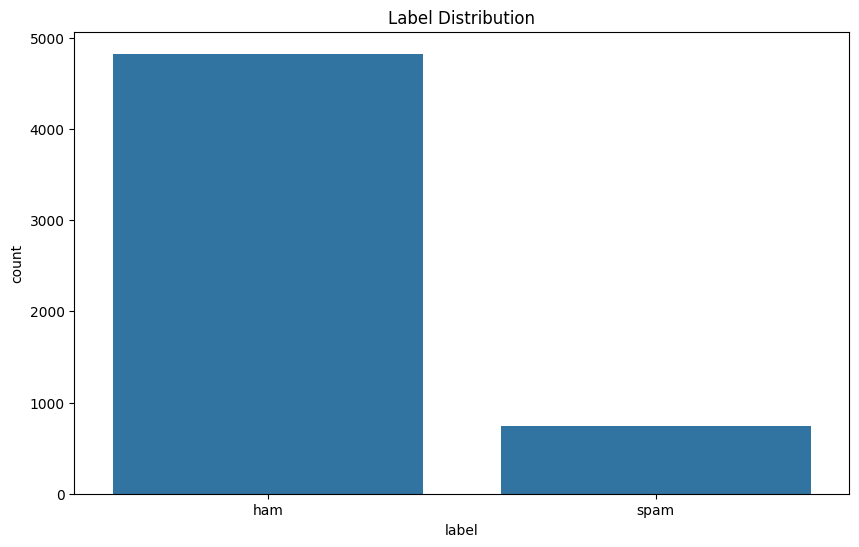

,count
label,
ham,4825
spam,747


In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

df.label.value_counts()

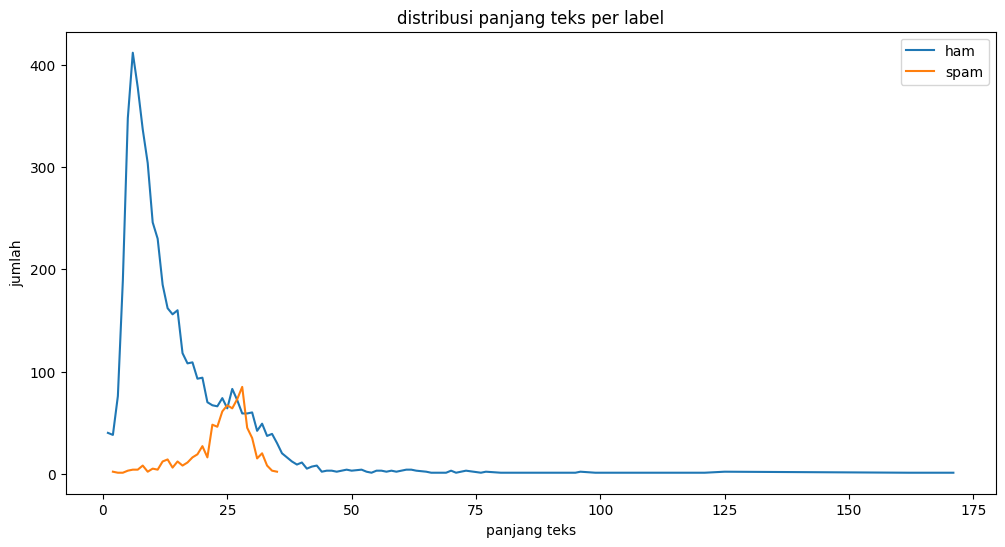

In [9]:
ham_df = df[df['label'] == 'ham']['text_len'].value_counts().sort_index()
spam_df = df[df['label'] == 'spam']['text_len'].value_counts().sort_index()


plt.figure(figsize=(12,6))
plt.plot(ham_df.index, ham_df.values, label='ham')
plt.plot(spam_df.index, spam_df.values, label='spam')
plt.title('distribusi panjang teks per label')
plt.xlabel('panjang teks')
plt.ylabel('jumlah')
plt.legend()
plt.show()

### preprocessing

In [10]:
def clean_text(text):
  text = text.lower()
  text = re.sub(f"[{string.punctuation}]", "", text)
  return text

In [11]:
df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,label,text,text_len,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


In [12]:
le = LabelEncoder()
le.fit(df['label'])

df['label'] = le.transform(df['label'])
df.head()

,label,text,text_len,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


### modelling

In [13]:
#### split data

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [14]:
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [15]:
gauss = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('classifier', GaussianNB())
])

multi = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2)),
    ('classifier', MultinomialNB(alpha=1.0))
])

bernoulli = Pipeline([
    ('vectorizer', CountVectorizer(binary=True, min_df=2)),
    ('classifier', BernoulliNB(alpha=1.0))
])

In [37]:
scoring = {
    'precision_spam': make_scorer(precision_score, pos_label=1),
    'recall_spam': make_scorer(recall_score, pos_label=1),
    'pr_auc': 'average_precision'
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

results = {}

for name, model in zip(
    ['gauss', 'multi', 'bernoulli'],
    [gauss, multi, bernoulli]
):
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )

    results[(name, 'Score')] = {
        'Precision': cv_results['test_precision_spam'].mean(),
        'Recall': cv_results['test_recall_spam'].mean(),
        'PR AUC': cv_results['test_pr_auc'].mean()
    }

    results[(name, 'Mean ± Std')] = {
        'Precision': f"{cv_results['test_precision_spam'].mean():.4f} ± {cv_results['test_precision_spam'].std():.4f}",
        'Recall': f"{cv_results['test_recall_spam'].mean():.4f} ± {cv_results['test_recall_spam'].std():.4f}",
        'PR AUC': f"{cv_results['test_pr_auc'].mean():.4f} ± {cv_results['test_pr_auc'].std():.4f}"
    }

In [39]:
results_df = pd.DataFrame(results).T
print("gauss vs multinomial vs bernoulli")
print(f"\n{results_df}")

gauss vs multinomial vs bernoulli

                            Precision           Recall           PR AUC
gauss     Score               0.54082         0.928025         0.511878
          Mean ± Std  0.5408 ± 0.0207  0.9280 ± 0.0218  0.5119 ± 0.0268
multi     Score              0.959758         0.914692         0.958819
          Mean ± Std  0.9598 ± 0.0113  0.9147 ± 0.0113  0.9588 ± 0.0047
bernoulli Score              0.984457         0.852815         0.978082
          Mean ± Std  0.9845 ± 0.0081  0.8528 ± 0.0205  0.9781 ± 0.0052
